# Lecture 13 – Data 100, Fall 2023

Data 100, Fall 2023

[Acknowledgments Page](https://ds100.org/fa23/acks/)

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />


## Minimizing an Arbitrary 1D Function

Suppose we want to find the value of $x$ that minimizes the arbitrary function given below:

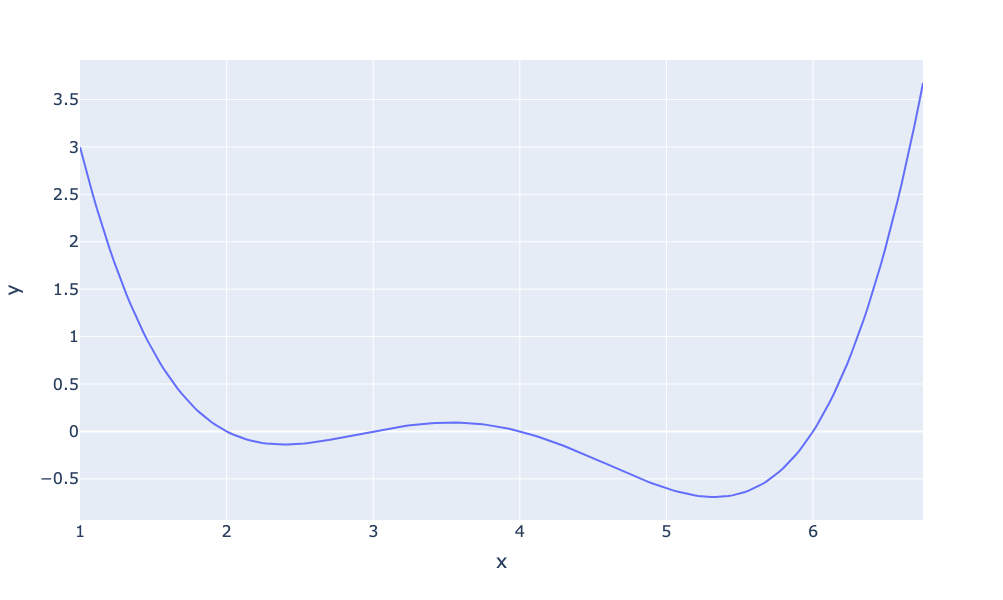

In [76]:
def arbitrary(x):
    return (x**4 - 15*x**3 + 80*x**2 - 180*x + 144)/10

x = np.linspace(1, 6.75, 200)
fig = px.line(y = arbitrary(x), x = x)


fig.update_layout(font_size = 16)
fig.update_layout(autosize=False, width=800, height=600)

### The Naive Approach: Guess and Check

Above, we saw that the minimum is somewhere around 5.3ish. Let's see if we can figure out how to find the exact minimum algorithmically from scratch.

One way very slow and terrible way would be manual guess-and-check.

In [3]:
arbitrary(6)

0.0

A somewhat better (but still slow) approach is to use brute force to try out a bunch of x values and return the one that yields the lowest loss.

In [4]:
def simple_minimize(f, xs):
    y = [f(x) for x in xs]  
    return xs[np.argmin(y)]

In [5]:
guesses = [5.3, 5.31, 5.32, 5.33, 5.34, 5.35]
simple_minimize(arbitrary, guesses)

5.33

This process is essentially the same as before where we made a graphical plot, it's just that we're only looking at 20 selected points.

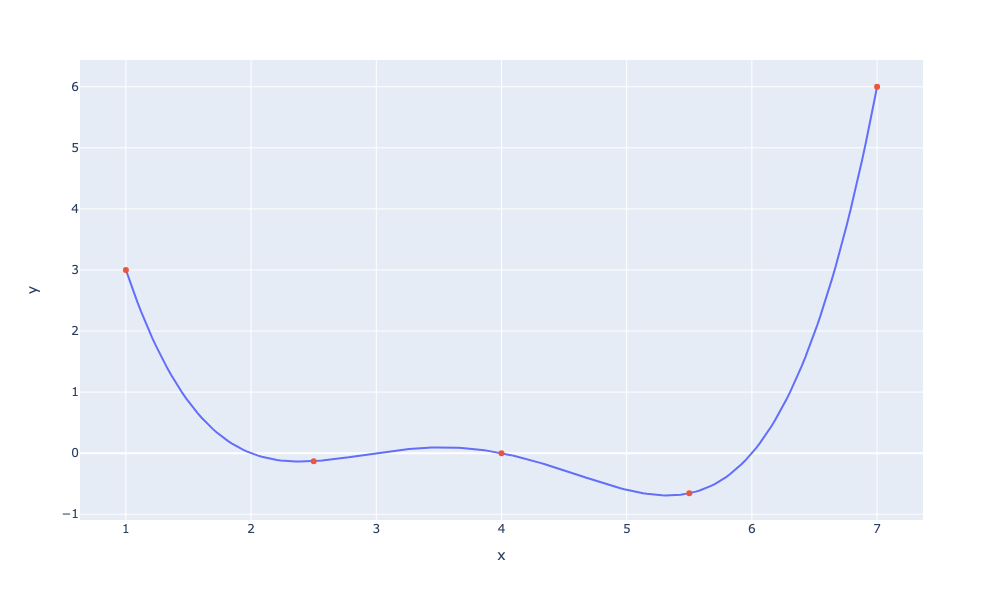

In [42]:
xs = np.linspace(1, 7, 200)
sparse_xs = np.linspace(1, 7, 5)

ys = arbitrary(xs)
sparse_ys = arbitrary(sparse_xs)

fig = px.line(x = xs, y = arbitrary(xs))
fig.add_scatter(x = sparse_xs, y = arbitrary(sparse_xs), mode = "markers")
fig.update_layout(showlegend= False)
fig.update_layout(autosize=False, width=800, height=600)
fig.show()

This basic approach suffers from three major flaws:
1. If the minimum is outside our range of guesses, the answer will be completely wrong.
2. Even if our range of guesses is correct, if the guesses are too coarse, our answer will be inaccurate.
3. It is absurdly computationally inefficient, considering potentially vast numbers of guesses that are useless.

### `scipy.optimize.minimize`

One way to minimize this mathematical function is to use the `scipy.optimize.minimize` function. It takes a function and a starting guess and tries to find the minimum.

In [7]:
from scipy.optimize import minimize

minimize(arbitrary, x0 = 3.5)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.13827491292966557
        x: [ 2.393e+00]
      nit: 3
      jac: [ 6.486e-06]
 hess_inv: [[ 7.385e-01]]
     nfev: 20
     njev: 10

`scipy.optimize.minimize` is great. It may also seem a bit magical. How can this one line of code find the minimum of any mathematical function so quickly? 

Behind the scenes, `scipy.optimize.minimize` uses a technique called **gradient descent** to compute the minimizing value of a function. In this lecture, we will learn the underlying theory behind gradient descent, then implement it ourselves.

### Better Approach: Gradient Descent

Instead of choosing all of our guesses ahead of time, we can instead start from a single guess and try to iteratively improve on our choice. 

They key insight is this: If the derivative of the function is negative, that means the function is decreasing, so we should go to the right (i.e. pick a bigger x). If the derivative of the function is positive, that means the function is increasing, so we should go to the left (i.e. pick a smaller x).

Thus, the derivative tells us which way to go.

Desmos demo: https://www.desmos.com/calculator/twpnylu4lr

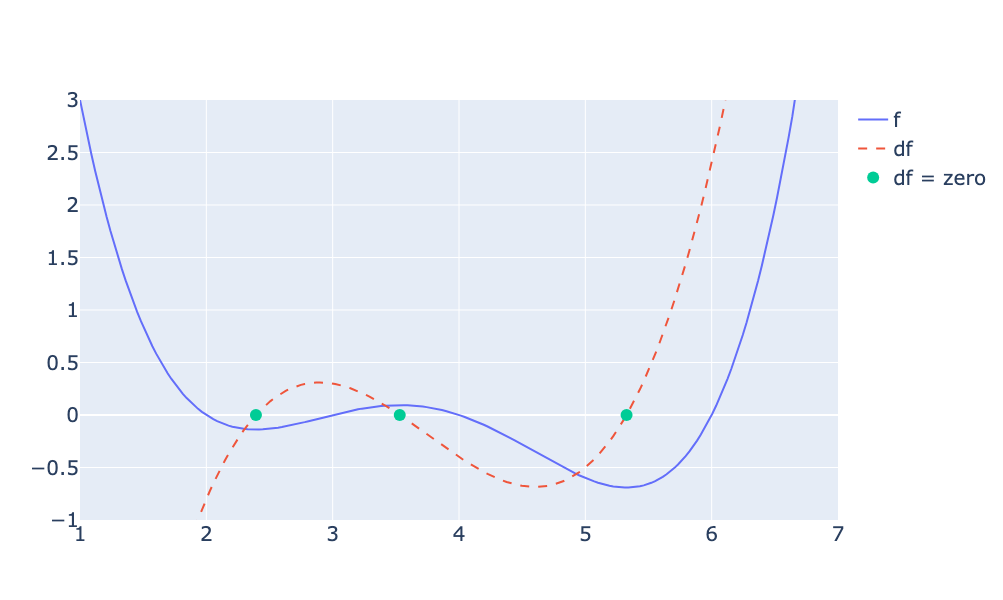

In [43]:
import plotly.graph_objects as go

def derivative_arbitrary(x):
    return (4*x**3 - 45*x**2 + 160*x - 180)/10


fig = go.Figure()
roots = np.array([2.3927, 3.5309, 5.3263])

fig.add_trace(go.Scatter(x = xs, y = arbitrary(xs), 
                         mode = "lines", name = "f"))
fig.add_trace(go.Scatter(x = xs, y = derivative_arbitrary(xs), 
                         mode = "lines", name = "df", line = {"dash": "dash"}))
fig.add_trace(go.Scatter(x = np.array(roots), y = 0*roots, 
                         mode = "markers", name = "df = zero", marker_size = 12))
fig.update_layout(font_size = 20, yaxis_range=[-1, 3])
fig.update_layout(autosize=False, width=800, height=600)
fig.show()

In [44]:
# Define some utility functions for the next example
import matplotlib.pyplot as plt

def plot_arbitrary():
    x = np.linspace(1, 7, 100)
    plt.plot(x, arbitrary(x))
    axes = plt.gca()
    axes.set_ylim([-1, 3])
    
def plot_x_on_f(f, x):
    y = f(x)    
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c=sns.xkcd_rgb['green'])
    plt.scatter([x], [y], **default_args)
    
def plot_x_on_f_empty(f, x):
    y = f(x)
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c = 'none', edgecolor=sns.xkcd_rgb['green'])
    plt.scatter([x], [y], **default_args)    
    
def plot_tangent_on_f(f, x, eps=1e-6):
    slope = ((f(x + eps) - f(x - eps))
             / (2 * eps))
    xs = np.arange(x - 1, x + 1, 0.05)
    ys = f(x) + slope * (xs - x)
    plt.plot(xs, ys, zorder=3, c=sns.xkcd_rgb['green'], linestyle='--')    

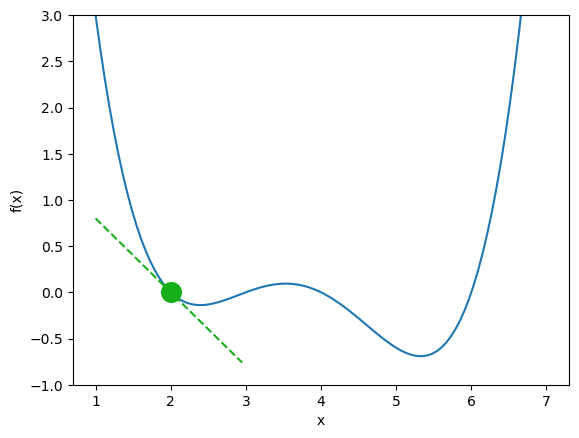

In [45]:
plot_arbitrary()
plot_x_on_f(arbitrary, 2)
plot_tangent_on_f(arbitrary, 2)
plt.xlabel('x')
plt.ylabel('f(x)');

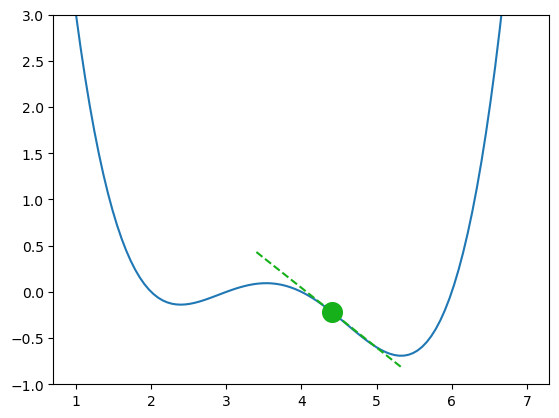

In [46]:
plot_arbitrary()
plot_x_on_f(arbitrary, 4.4)
plot_tangent_on_f(arbitrary, 4.4)

## Manually Descending the Gradient

Armed with this knowledge, let's try to see if we can use the derivative to optimize the function.

We start by making some guess for the minimizing value of $x$. Then, we look at the derivative of the function at this value of $x$, and step downhill in the *opposite* direction. We can express our new rule as a recurrence relation:

$$x^{(t+1)} = x^{(t)} - \frac{d}{dx} f(x^{(t)})$$

Translating this statement into English: we obtain **our next guess** for the minimizing value of $x$ at timestep $t+1$ ($x^{(t+1)}$) by taking the guess **our last guess** ($x^{(t)}$) and subtracting the **derivative of the function** at that point ($\frac{d}{dx} f(x^{(t)})$).

`arbitrary` represents the function we are trying to minimize, $f$. 

`derivative_arbitrary` represents the first derivative of this function, $\frac{df}{dx}$.


In [47]:
def plot_one_step(x):
    # Find our new guess using the recurrence relation
    new_x = x - derivative_arbitrary(x)
    
    # Plot our old guess and our new guess on the function
    plot_arbitrary()
    plot_x_on_f(arbitrary, new_x)
    plot_x_on_f_empty(arbitrary, x)
    print(f'old x: {x}')
    print(f'new x: {new_x}')    

old x: 4
new x: 4.4


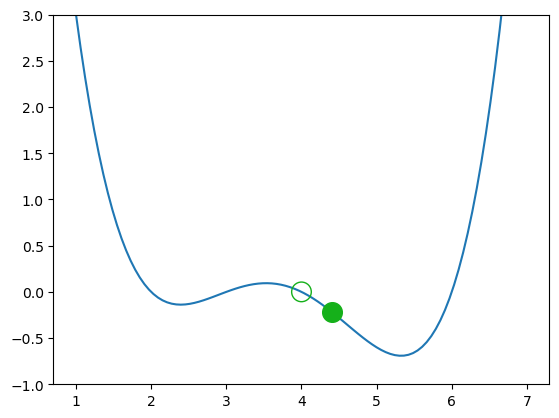

In [48]:
plot_one_step(4)

old x: 4.4
new x: 5.0464000000000055


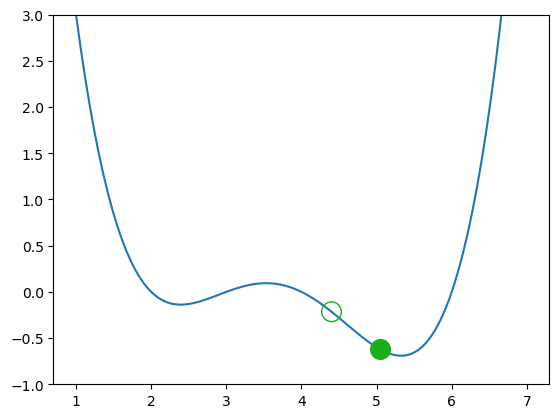

In [49]:
plot_one_step(4.4)

old x: 5.0464
new x: 5.49673060106241


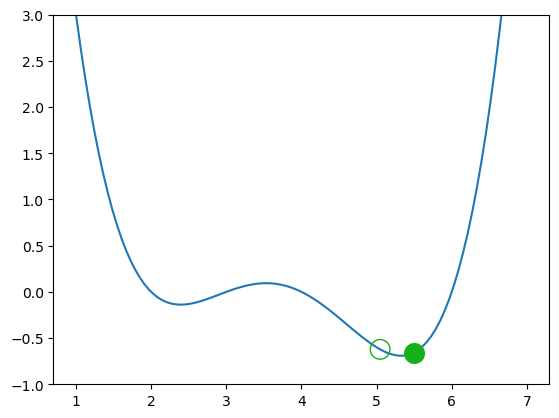

In [50]:
plot_one_step(5.0464)

old x: 5.4967
new x: 5.080917145374805


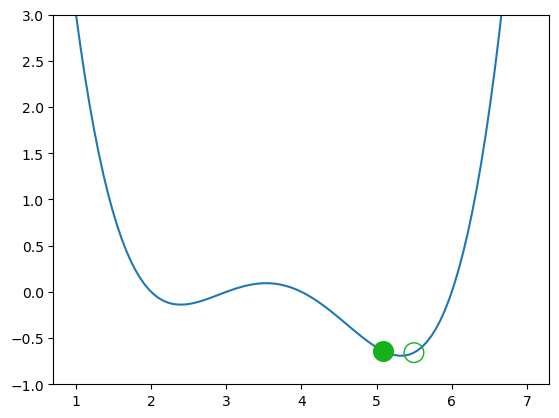

In [51]:
plot_one_step(5.4967)

old x: 5.080917145374805
new x: 5.489966698640582


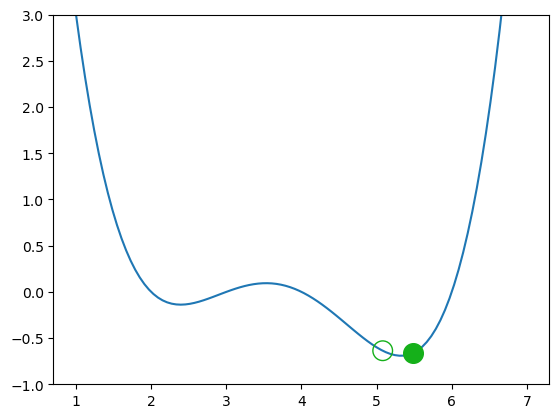

In [52]:
plot_one_step(5.080917145374805)

old x: 5.489966698640582
new x: 5.092848945470474


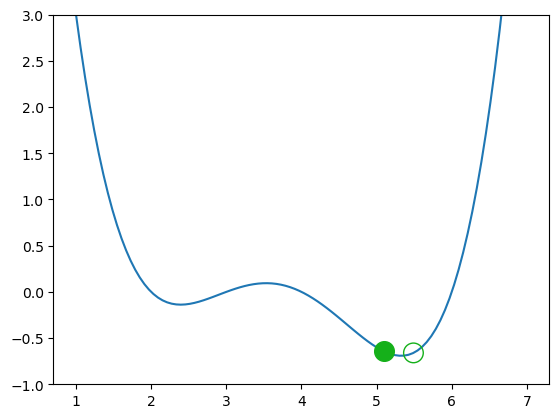

In [53]:
plot_one_step(5.489966698640582)

Looking pretty good! We do have a problem though – once we arrive close to the minimum value of the function, our guesses "bounce" back and forth past the minimum without ever reaching it.

In other words, each step we take when updating our guess moves us too far. We can address this by decreasing the size of each step. 

Let's update our algorithm to use a **learning rate** (also sometimes called the step size), which controls how far we move with each update. We represent the learning rate with $\alpha$. 

$$x^{(t+1)} = x^{(t)} - \alpha \frac{d}{dx} f(x^{(t)})$$

A small $\alpha$ means that we will take small update steps; a large $\alpha$ means we will take large steps. 

Let's update our function to use $\alpha=0.3$.

In [54]:
def plot_one_step_lr(x):
    # Implement our new algorithm with a learning rate
    new_x = x - 0.3 * derivative_arbitrary(x)
    
    # Plot the updated guesses
    plot_arbitrary()
    plot_x_on_f(arbitrary, new_x)
    plot_x_on_f_empty(arbitrary, x)
    print(f'old x: {x}')
    print(f'new x: {new_x}')    

old x: 4
new x: 4.12


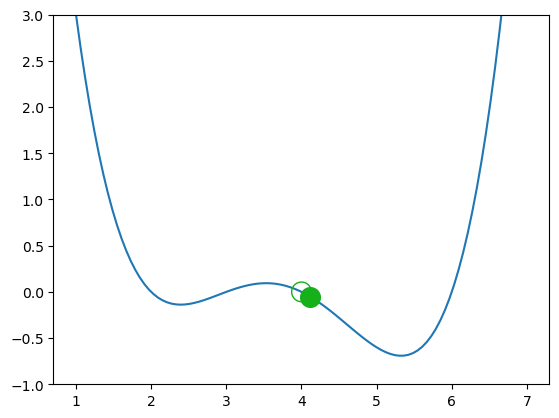

In [55]:
plot_one_step_lr(4)

old x: 4.12
new x: 4.267296639999997


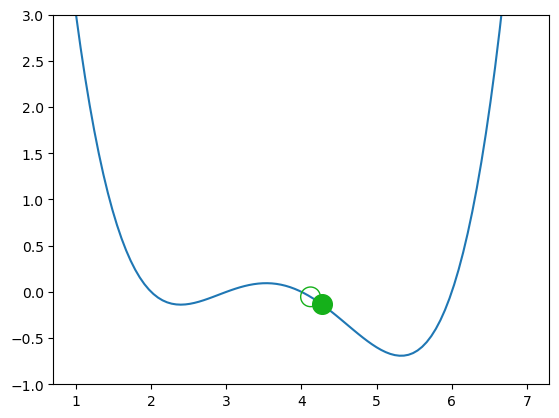

In [56]:
plot_one_step_lr(4.12)

old x: 5.17180969114245
new x: 5.256374838146257


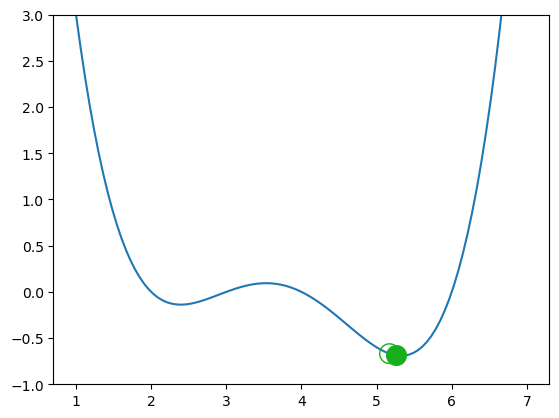

In [57]:
plot_one_step_lr(5.17180969114245)

old x: 5.323
new x: 5.325108157959999


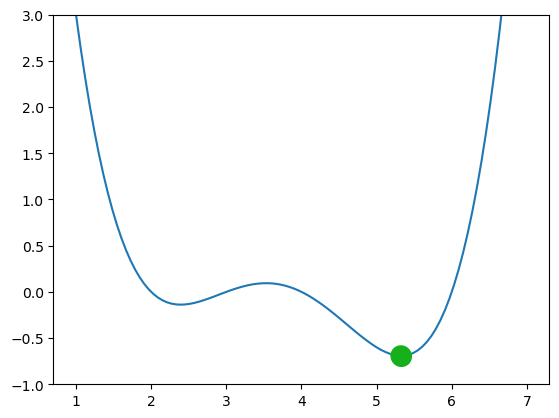

In [58]:
plot_one_step_lr(5.323)

## Formalizing Gradient Descent

The process we just explored above is called **gradient descent** – we compute the derivative of a function (its *gradient*) with respect to the variable we wish to optimize, then *descend* down to the minimum of the function. 

$$
x^{(t+1)} = x^{(t)} -  \alpha \frac{d}{dx} f(x)
$$

In the cell below, we define `gradient_descent`, which runs the gradient descent algorithm for a specified number `n` of updates and stores all guesses. 

In [59]:
def gradient_descent(df, initial_guess, alpha, n):
    """Performs n steps of gradient descent on df using learning rate alpha starting
       from initial_guess. Returns a numpy array of all guesses over time."""
    guesses = [initial_guess]
    current_guess = initial_guess
    while len(guesses) < n:
        current_guess = current_guess - alpha * df(current_guess)
        guesses.append(current_guess)
        
    return np.array(guesses)

Below, we see a visualization of the trajectory taken by this algorithm. Try modifying the `initial_guess`, learning rate `alpha`, and number of updates `n`. 

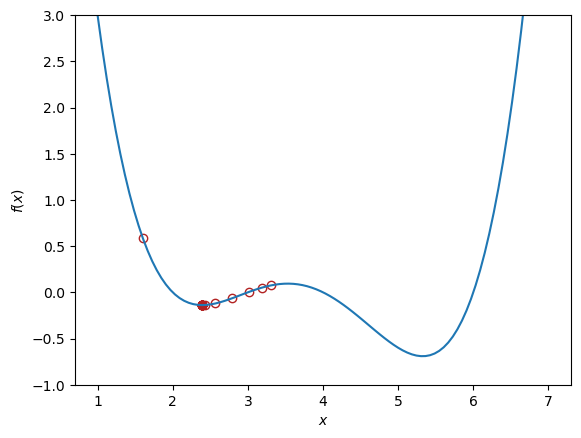

In [60]:
trajectory = gradient_descent(derivative_arbitrary, 1.6, 0.75, 20)

plot_arbitrary()
plt.scatter(trajectory, arbitrary(trajectory), c="white", edgecolor="firebrick")
plt.scatter(trajectory[-1], arbitrary(trajectory[-1]), c="firebrick")
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$");

Above, we've simply run our algorithm a fixed number of times. More sophisticated implementations will stop based on a variety of different stopping criteria, e.g. error getting too small, error getting too large, etc. We will not discuss these in our course.

In the next part, we'll return to the world of real data and see how this procedure might be useful for optimizing models.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Gradient Descent on a 1D Model

In our discussion above, we worked with some arbitrary function $f$. As data scientists, we will almost always work with gradient descent in the context of optimizing *models* – specifically, we want to apply gradient descent to find the minimum of a *loss function*. 

Recall our modeling workflow from the past few lectures: 
* Define a model with some parameters $\theta_i$
* Choose a loss function 
* Select the values of $\theta_i$ that minimize the loss function on the data

Gradient descent is a powerful technique for completing this last task. By applying the gradient descent algorithm, we can select values for our parameters $\theta_i$ that will lead to the model having minimal loss on the training data.

When using gradient descent in a modeling context:
* We make guesses for the minimizing $\theta_i$
* We compute the derivative of the loss function $L$

We can "translate" our gradient descent rule from before:

$$\theta^{(t+1)} = \theta^{(t)} - \alpha \frac{d}{d\theta} L(\theta^{(t)})$$

To see this in action, let's consider a case where we have a linear model with no offset. 

$$\hat{y} = \theta_1 x$$

We want to find the parameter $\theta_1$ such that the mean squared error is minimized. Our loss function is:

$$L(\theta) = MSE(\theta) = \frac{1}{n} \sum_{i=1}^n (y_i - \theta_1x_i)^2$$

Let's apply our `gradient_descent` function from before to optimize our model on the `tips` dataset. We will try to select the best parameter $\theta_i$ to predict the `tip` $y$ from the `total_bill` $x$.

In [61]:
df = sns.load_dataset("tips")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


We can visualize the value of the MSE on our dataset for different possible choices of $\theta_1$. To optimize our model, we want to select the value of $\theta_1$ that leads to the lowest MSE.

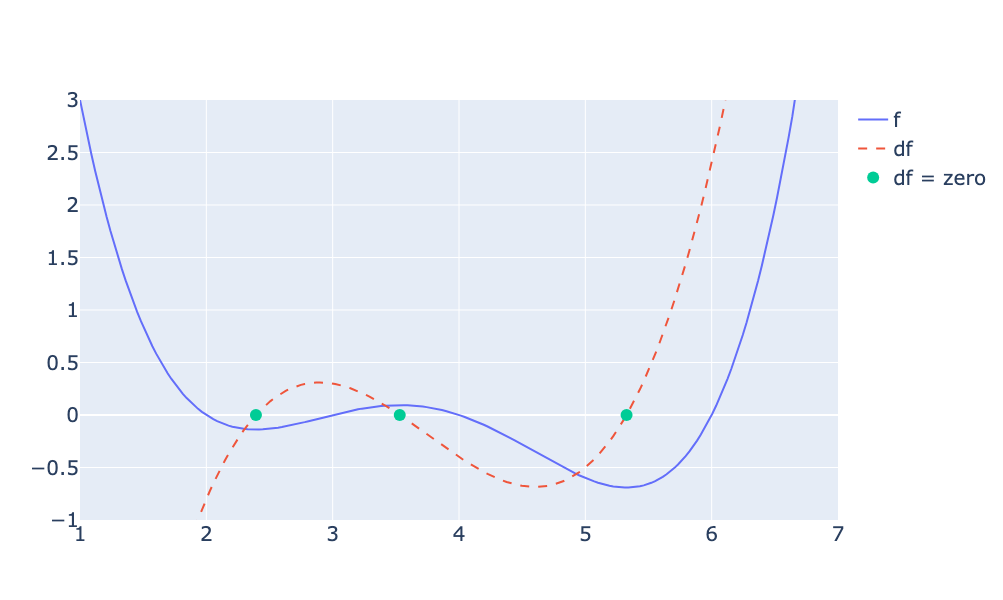

In [64]:
def mse_single_arg(theta_1):
    """Returns the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    return np.mean((y_hat - y_obs) ** 2) 

loss_df = pd.DataFrame({"theta_1":np.linspace(-1.5, 1), "MSE":[mse_single_arg(theta_1) for theta_1 in np.linspace(-1.5, 1)]})

px.line(loss_df, x="theta_1", y="MSE")
fig.update_layout(autosize=False, width=800, height=600)

To apply gradient descent, we need to compute the derivative of the loss function with respect to our parameter $\theta_1$. This comes out to be:

$$\frac{d}{d\theta_1} L(\theta^{(t)}) = \frac{-1}{n} \sum_{i=1}^n (y_i - \theta_1^{(t)}x_i)x_i$$

Here, we denote our parameter as $\theta_1^{(t)}$ to remind ourselves that we compute the derivative assuming $\theta_i$ has the value of our *current* guess. 

Our gradient descent update rule is:

$$\theta_1^{(t+1)} = \theta_1^{(t)} - \alpha \frac{-1}{n} \sum_{i=1}^n (y_i - \theta_1^{(t)}x_i)x_i$$

For some learning rate $\alpha$.

In [65]:
def gradient_descent(df, initial_guess, alpha, n):
    """Performs n steps of gradient descent on df using learning rate alpha starting
       from initial_guess. Returns a numpy array of all guesses over time."""
    guesses = [initial_guess]
    current_guess = initial_guess
    while len(guesses) < n:
        current_guess = current_guess - alpha * df(current_guess)
        guesses.append(current_guess)
        
    return np.array(guesses)

To use this function, we need to compute the derivative of the MSE. The MSE is repeated below for convenience.

In [66]:
def mse_single_arg(theta_1):
    """Returns the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    return np.mean((y_hat - y_obs) ** 2) 

The derivative of the MSE with respect to `theta_1` is:

In [67]:
def mse_loss_derivative_single_arg(theta_1):
    """Returns the derivative of the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    
    return np.mean(2 * (y_hat - y_obs) * x)

Now, we can apply gradient descent to select a value for $\theta_1$.

Final guess for theta_1: 0.14369554654231262


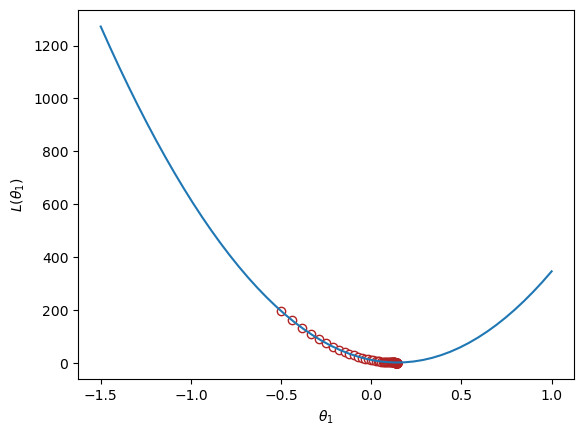

In [68]:
trajectory = gradient_descent(mse_loss_derivative_single_arg, -0.5, 0.0001, 100)

plt.plot(loss_df["theta_1"], loss_df["MSE"])
plt.scatter(trajectory, [mse_single_arg(guess) for guess in trajectory], c="white", edgecolor="firebrick")
plt.scatter(trajectory[-1], mse_single_arg(trajectory[-1]), c="firebrick")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$L(\theta_1)$");

print(f"Final guess for theta_1: {trajectory[-1]}")

## Gradient Descent on Multi-Dimensional Models

Now suppose we improve our model so that we want to predict the tip from the total_bill plus a constant offset, in other words:

$$\textrm{tip} = \theta_0 + \theta_1 \textrm{bill}$$

Our simple linear regression model has *two* parameters, $\theta_0$ and $\theta_1$. We need to optimize both of them.

Fortunately, gradient descent readily extends to models with multiple dimenions.

#### Defining a 2D MSE Function

Now, we can give our predictions as $$\hat{y} = \theta_0 + \theta_1 x_1$$

In the cell below, we add a bias term to our data to represent the constant intercept $\theta_0$.

In [69]:
tips_with_bias = df.copy()
tips_with_bias["bias"] = 1
tips_with_bias = tips_with_bias[["bias", "total_bill"]]

tips_with_bias.head()

,bias,total_bill
0,1,16.99
1,1,10.34
2,1,21.01
3,1,23.68
4,1,24.59


Throughout this problem, we'll assume we want to minimize the mean squared error of our predictions, i.e.

In [70]:
def mse_loss(theta, X, y_obs):
    y_hat = X @ theta
    return np.mean((y_hat - y_obs) ** 2)    

Using this function, we can visualize our loss function. Because we now want to understand how the loss changes with respect to *two* parameters, we create a **loss surface**. Each point on the surface represents the loss of the model for a particular choice of $\theta_0$ and $\theta_1$.


The cell below uses lots of syntax you've never seen. No need to worry about any unfamiliar plotting code; for now, focus on the output.

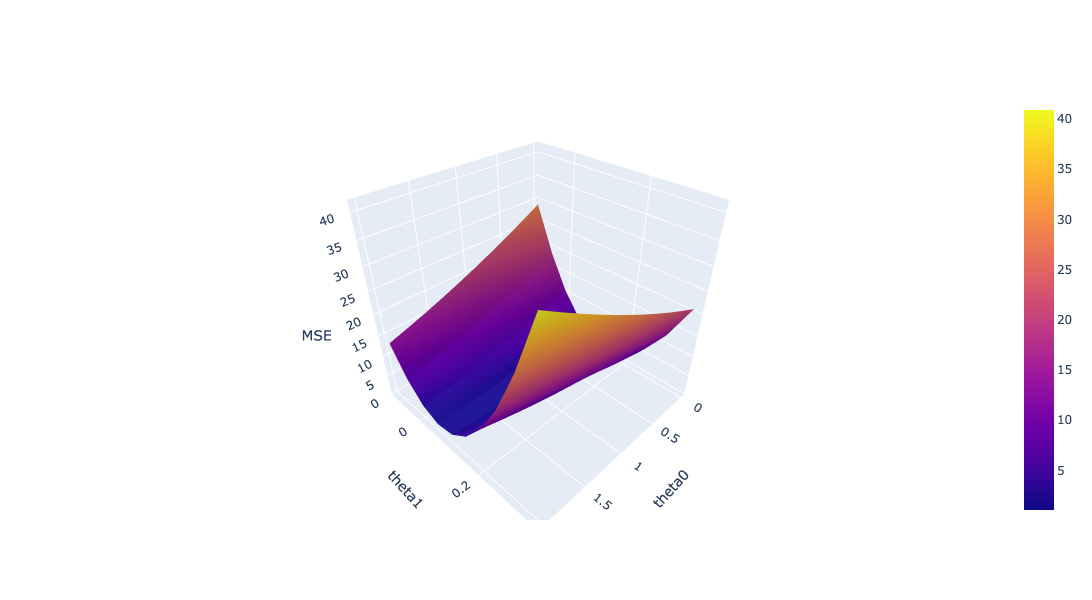

In [71]:
import plotly.graph_objects as go

uvalues = np.linspace(0, 2, 10)
vvalues = np.linspace(-0.1, 0.35, 10)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))

def mse_loss_single_arg(theta):
    return mse_loss(theta, tips_with_bias, df["tip"])

MSE = np.array([mse_loss_single_arg(t) for t in thetas.T])

loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape))

ind = np.argmin(MSE)
optimal_point = go.Scatter3d(name = "Optimal Point",
    x = [thetas.T[ind,0]], y = [thetas.T[ind,1]], 
    z = [MSE[ind]],
    marker=dict(size=10, color="red"))

fig = go.Figure(data=[loss_surface, optimal_point])
fig.update_layout(scene = dict(
    xaxis_title = "theta0",
    yaxis_title = "theta1",
    zaxis_title = "MSE"), autosize=False, width=800, height=600)

fig.show()

Play around with the plot above. We have marked the lowest point on the surface in red – this is the combination of $\theta_0$ and $\theta_1$ that leads to the lowest MSE for the model.

Alternatively, we can visualize a bird's-eye view of the loss surface from above using a contour plot: 

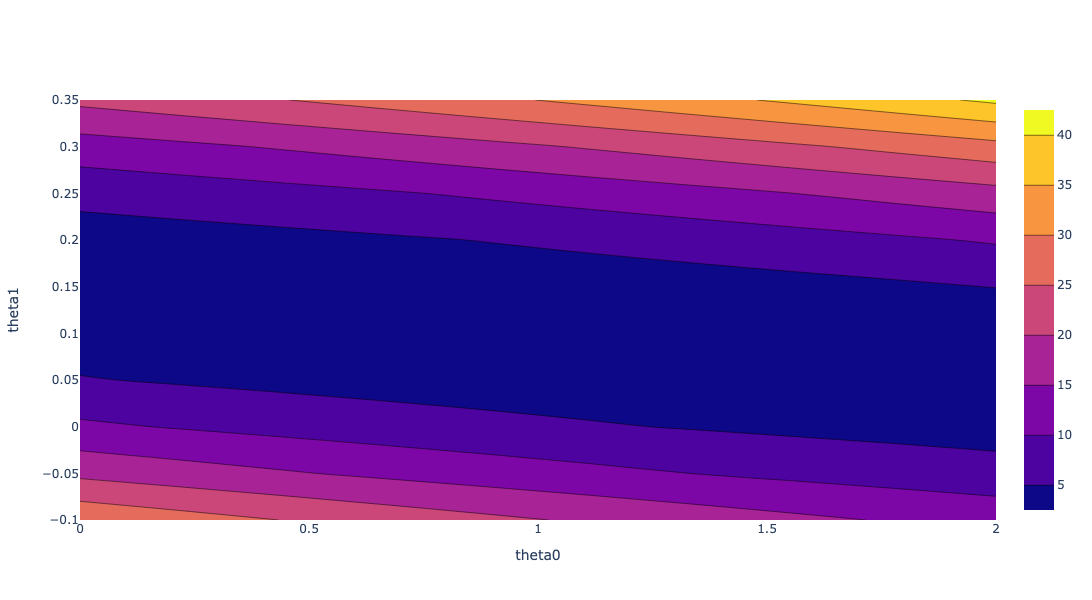

In [72]:
contour = go.Contour(x=u[0], y=v[:, 0], z=np.reshape(MSE, u.shape))
fig = go.Figure(contour)
fig.update_layout(
    xaxis_title = "theta0",
    yaxis_title = "theta1", autosize=False, width=800, height=600)

fig.show()

#### Applying Gradient Descent in 2D

When working with multidimensional models, we optimize a *vector* of parameters. Our new update rule is:

$$\vec{\theta}^{(t+1)} = \vec{\theta}^{(t)} - \alpha \nabla_{\vec{\theta}} L(\vec{\theta}^{(t)})$$

Where $\nabla_{\vec{\theta}} L(\vec{\theta}^{(t)})$ is the **gradient** of the loss function. It is the vector of the partial derivatives of loss with respect to each parameter $\theta_i$.

In the cell below, we define helper functions to compute the gradient of MSE with respect to our two parameters $\theta_0$ and $\theta_1$, stored in the array `theta`.

In [73]:
df_with_bias = df.copy()
df_with_bias["bias"] = 1

def mse_gradient(theta, X, y_obs):
    """Returns the gradient of the MSE on our data for the given theta"""    
    x0 = X.iloc[:, 0]
    x1 = X.iloc[:, 1]
    dth0 = np.mean(-2 * (y_obs - theta[0]*x0 - theta[1]*x1) * x0)
    dth1 = np.mean(-2 * (y_obs - theta[0]*x0 - theta[1]*x1) * x1)
    return np.array([dth0, dth1])

def mse_gradient_single_arg(theta):
    """Returns the gradient of the MSE on our data for the given theta"""
    X = df_with_bias[["bias", "total_bill"]]
    y_obs = df["tip"]
    return mse_gradient(theta, X, y_obs)

def mse_single_arg(theta_1):
    """Returns the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    return np.mean((y_hat - y_obs) ** 2) 

Now, we can use our `gradient_descent` function from before to optimize $\theta_0$ and $\theta_1$ at the same time! The final estimates for the ideal model parameters are very similar to the guesses we may have made simply by inspecting the plot of the loss surface from before. 

The cell below may take a moment to run.

In [74]:
guesses = gradient_descent(mse_gradient_single_arg, np.array([0, 0]), 0.001, 10000)

pd.DataFrame(guesses, columns=["theta_0", "theta_1"]).tail(10)

,theta_0,theta_1
9990,0.888098,0.106378
9991,0.888108,0.106378
9992,0.888119,0.106377
9993,0.888130,0.106377
9994,0.888141,0.106376
9995,0.888151,0.106376
9996,0.888162,0.106375
9997,0.888173,0.106375
9998,0.888184,0.106375
9999,0.888194,0.106374


## Extra: The General Matrix Form of the Gradient

For the curious, the general matrix form of the gradient is given below. We will not discuss it in class.

In [75]:
def mse_gradient(theta, X, y_obs):
    """Returns the gradient of the MSE on our data for the given theta"""
    n = len(X)
    return -2 / n * (X.T @ y_obs - X.T @ X @ theta)